<a href="https://colab.research.google.com/github/fannix/timeseries_generation/blob/master/dynet_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. https://talbaumel.github.io/blog/attention/
2. https://towardsdatascience.com/attention-seq2seq-with-pytorch-learning-to-invert-a-sequence-34faf4133e53





In [0]:
%matplotlib inline
from random import choice, randrange

EOS = "<EOS>" #all strings will end with the End Of String token
characters = list("abcd")
characters.append(EOS)

int2char = list(characters)
char2int = {c:i for i,c in enumerate(characters)}

VOCAB_SIZE = len(characters)

def sample_model(min_length, max_lenth):
    random_length = randrange(min_length, max_lenth)                             # Pick a random length
    random_char_list = [choice(characters[:-1]) for _ in range(random_length)]  # Pick random chars
    random_string = ''.join(random_char_list) 
    return random_string, random_string[::-1]  # Return the random string and its reverse

In [2]:
print(sample_model(4, 5))
print(sample_model(5, 10))



('cccc', 'cccc')
('ddcccbcbc', 'cbcbcccdd')


In [0]:
MAX_STRING_LEN = 15

train_set = [sample_model(1, MAX_STRING_LEN) for _ in range(3000)]
val_set = [sample_model(1, MAX_STRING_LEN) for _ in range(50)]

In [5]:
!pip install dynet

     |████████████████████████████████| 28.1MB 1.8MB/s 


In [0]:

import matplotlib.pyplot as plt
import dynet as dy
from tqdm import tqdm_notebook as tqdm
def train(network, train_set, val_set, epochs = 20):
    def get_val_set_loss(network, val_set):
        loss = [network.get_loss(input_string, output_string).value() for input_string, output_string in val_set]
        return sum(loss)
    
    train_set = train_set*epochs
    trainer = dy.SimpleSGDTrainer(network.model)
    losses = []
    iterations = []
    for i, training_example in enumerate(tqdm(train_set)):
        input_string, output_string = training_example
        
        loss = network.get_loss(input_string, output_string)
        loss_value = loss.value()
        loss.backward()
        trainer.update()

        # Accumulate average losses over training to plot
        if i%(len(train_set)/100) == 0:
            val_loss = get_val_set_loss(network, val_set)
            losses.append(val_loss)
            iterations.append(i/((len(train_set)/100)))

    plt.plot(iterations, losses)
    plt.axis([0, 100, 0, len(val_set)*MAX_STRING_LEN])
    plt.show() 
    print('loss on validation set:', val_loss)



In [0]:
RNN_BUILDER = dy.LSTMBuilder

class SimpleRNNNetwork:
    def __init__(self, rnn_num_of_layers, embeddings_size, state_size):
        self.model = dy.Model()

        # the embedding paramaters
        self.embeddings = self.model.add_lookup_parameters((VOCAB_SIZE, embeddings_size))

        # the rnn
        self.RNN = RNN_BUILDER(rnn_num_of_layers, embeddings_size, state_size, self.model)

        # project the rnn output to a vector of VOCAB_SIZE length
        self.output_w = self.model.add_parameters((VOCAB_SIZE, state_size))
        self.output_b = self.model.add_parameters((VOCAB_SIZE))
    
    def _pre_process(self, string):
        string = list(string) + [EOS]
        return [char2int[c] for c in string]
    
    def _embed_string(self, string):
        return [self.embeddings[char] for char in string]

    def _run_rnn(self, init_state, input_vecs):
        s = init_state

        states = s.add_inputs(input_vecs)
        rnn_outputs = [s.output() for s in states]
        return rnn_outputs
    
    def _get_probs(self, rnn_output):
        probs = dy.softmax(self.output_w * rnn_output + self.output_b)
        return probs
    
    def __call__(self, input_string):
        input_string = self._pre_process(input_string)
        
        dy.renew_cg()
        
        embedded_string = self._embed_string(input_string)
        rnn_state = self.RNN.initial_state()
        rnn_outputs = self._run_rnn(rnn_state, embedded_string)
        return [self._get_probs(rnn_output) for rnn_output in rnn_outputs]

            
    def get_loss(self, input_string, output_string):
        output_string = self._pre_process(output_string)

        probs = self(input_string)
        loss = [-dy.log(dy.pick(p, output_char)) for p, output_char in zip(probs, output_string)]
        loss = dy.esum(loss)
        return loss

    def _predict(self, probs):
        probs = probs.value()
        predicted_char = int2char[probs.index(max(probs))]
        return predicted_char
    
    def generate(self, input_string):
        probs = self(input_string)
        output_string = [self._predict(p) for p in probs]
        output_string = ''.join(output_string)
        return output_string.replace('<EOS>', '')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


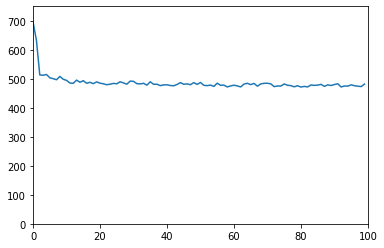

loss on validation set: 481.95005786418915
bbb


In [8]:
RNN_NUM_OF_LAYERS = 2
EMBEDDINGS_SIZE = 4
STATE_SIZE = 128


rnn = SimpleRNNNetwork(RNN_NUM_OF_LAYERS, EMBEDDINGS_SIZE, STATE_SIZE)
train(rnn, train_set, val_set, epochs = 5)
print(rnn.generate('abc'))

In [0]:
class BiRNNNetwork(SimpleRNNNetwork):
    def __init__(self, rnn_num_of_layers, embeddings_size, state_size):
        self.model = dy.Model()

        # the embedding paramaters
        self.embeddings = self.model.add_lookup_parameters((VOCAB_SIZE, embeddings_size))

        # the foreword rnn
        self.fwd_RNN = RNN_BUILDER(rnn_num_of_layers, embeddings_size, state_size, self.model)
        # the backword rnn
        self.bwd_RNN = RNN_BUILDER(rnn_num_of_layers, embeddings_size, state_size, self.model)

        # project the rnn output to a vector of VOCAB_SIZE length
        self.output_w = self.model.add_parameters((VOCAB_SIZE, state_size*2))
        self.output_b = self.model.add_parameters((VOCAB_SIZE))
    
    def __call__(self, input_string):
        input_string = self._pre_process(input_string)
        
        dy.renew_cg()

        embedded_string = self._embed_string(input_string)
        
        #run the foreword RNN
        rnn_fwd_state = self.fwd_RNN.initial_state()
        rnn_fwd_outputs = self._run_rnn(rnn_fwd_state, embedded_string)
        
        #run the backword rnn
        rnn_bwd_state = self.bwd_RNN.initial_state()
        rnn_bwd_outputs = self._run_rnn(rnn_bwd_state, embedded_string[::-1])[::-1]
        
        #concataenate the foreward and backword outputs
        rnn_outputs = [dy.concatenate([fwd_out, bwd_out]) for fwd_out, bwd_out in zip(rnn_fwd_outputs, rnn_bwd_outputs)]
        
        loss = []
        probs = [self._get_probs(rnn_output) for rnn_output in rnn_outputs]
            
        return probs

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


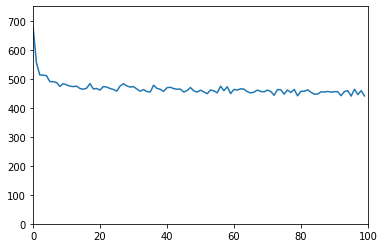

loss on validation set: 440.94241666793823
ccc


In [10]:
RNN_NUM_OF_LAYERS = 2
EMBEDDINGS_SIZE = 4
STATE_SIZE = 64


birnn = BiRNNNetwork(RNN_NUM_OF_LAYERS, EMBEDDINGS_SIZE, STATE_SIZE)
train(birnn, train_set, val_set, epochs = 5)
print(birnn.generate('abc'))


In [0]:
class EncoderDecoderNetwork(SimpleRNNNetwork):
    def __init__(self, enc_layers, dec_layers, embeddings_size, enc_state_size, dec_state_size):
        self.model = dy.Model()

        # the embedding paramaters
        self.embeddings = self.model.add_lookup_parameters((VOCAB_SIZE, embeddings_size))

        # the rnns
        self.ENC_RNN = RNN_BUILDER(enc_layers, embeddings_size, enc_state_size, self.model)
        self.DEC_RNN = RNN_BUILDER(dec_layers, enc_state_size, dec_state_size, self.model)

        # project the rnn output to a vector of VOCAB_SIZE length
        self.output_w = self.model.add_parameters((VOCAB_SIZE, dec_state_size))
        self.output_b = self.model.add_parameters((VOCAB_SIZE))

    def _encode_string(self, embedded_string):
        initial_state = self.ENC_RNN.initial_state()

        # run_rnn returns all the hidden state of all the slices of the RNN
        hidden_states = self._run_rnn(initial_state, embedded_string)

        return hidden_states

    def __call__(self, input_string):
        input_string = self._pre_process(input_string)
        
        dy.renew_cg()
        
        embedded_string = self._embed_string(input_string)
        # The encoded string is the hidden state of the last slice of the encoder
        encoded_string = self._encode_string(embedded_string)[-1]

        rnn_state = self.DEC_RNN.initial_state()

        probs = []
        for _ in range(len(input_string)):
            rnn_state = rnn_state.add_input(encoded_string)
            p = self._get_probs(rnn_state.output())
            probs.append(p)
        return probs

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


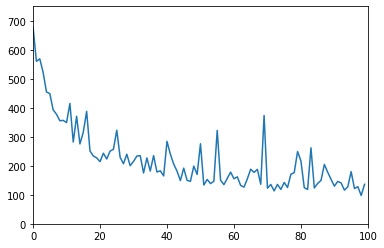

loss on validation set: 136.12782923810414
abcd -> dcba
abcdabcdabcdabcd -> dcbaaccccbadbb


In [12]:
ENC_RNN_NUM_OF_LAYERS = 1
DEC_RNN_NUM_OF_LAYERS = 1
EMBEDDINGS_SIZE = 4
ENC_STATE_SIZE = 64
DEC_STATE_SIZE = 64

encoder_decoder = EncoderDecoderNetwork(
    ENC_RNN_NUM_OF_LAYERS, DEC_RNN_NUM_OF_LAYERS, EMBEDDINGS_SIZE, ENC_STATE_SIZE, DEC_STATE_SIZE)
train(encoder_decoder, train_set, val_set)
print('abcd', '->', encoder_decoder.generate('abcd'))
print('abcdabcdabcdabcd', '->', encoder_decoder.generate('abcdabcdabcdabcd'))


In [13]:
short_strings = [sample_model(1, 5) for _ in range(100)]
medium_strings = [sample_model(5, 10) for _ in range(100)]
long_strings = [sample_model(10, 15) for _ in range(100)]

def count_matches(network, val_set):
    matches = [network.generate(input_string)==output_string for input_string, output_string in val_set]
    return matches.count(True)

print('Matches for short strings', count_matches(encoder_decoder, short_strings))
print('Matches for medium strings', count_matches(encoder_decoder, medium_strings))
print('Matches for long strings', count_matches(encoder_decoder, long_strings))

Matches for short strings 100
Matches for medium strings 84
Matches for long strings 26


In [0]:


class AttentionNetwork(EncoderDecoderNetwork):
    def __init__(self, enc_layers, dec_layers, embeddings_size, enc_state_size, dec_state_size):
        EncoderDecoderNetwork.__init__(self, enc_layers, dec_layers, embeddings_size, enc_state_size, dec_state_size)

        # attention weights
        self.attention_w1 = self.model.add_parameters((enc_state_size, enc_state_size))
        self.attention_w2 = self.model.add_parameters((enc_state_size, dec_state_size))
        self.attention_v = self.model.add_parameters((1, enc_state_size))

        self.enc_state_size = enc_state_size

    def _attend(self, input_vectors, state):
        attention_weights = []

        w2dt = self.attention_w2 * state.h()[-1]
        for input_vector in input_vectors:
            attention_weight = self.attention_v * dy.tanh(self.attention_w1  * input_vector + w2dt)
            attention_weights.append(attention_weight)
        attention_weights = dy.softmax(dy.concatenate(attention_weights))

        output_vectors = dy.esum(
            [vector * attention_weight 
             for vector, attention_weight 
             in zip(input_vectors, attention_weights)])
        return output_vectors

    def __call__(self, input_string):
        input_string = self._pre_process(input_string)
        
        dy.renew_cg()

        embedded_string = self._embed_string(input_string)
        encoded_string = self._encode_string(embedded_string)

        rnn_state = self.DEC_RNN.initial_state().add_input(dy.vecInput(self.enc_state_size))

        probs = []
        for _ in range(len(input_string)):
            attended_encoding = self._attend(encoded_string, rnn_state)
            rnn_state = rnn_state.add_input(attended_encoding)
            p = self._get_probs(rnn_state.output())
            probs.append(p)
        return probs



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


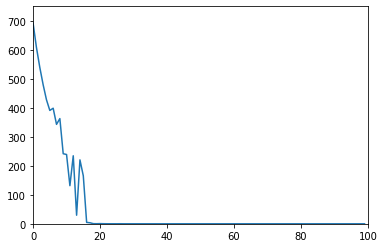

loss on validation set: 0.01025974439107813
dcadccbadcbadcba


In [15]:
ENC_RNN_NUM_OF_LAYERS = 1
DEC_RNN_NUM_OF_LAYERS = 1
EMBEDDINGS_SIZE = 4
ENC_STATE_SIZE = 32
DEC_STATE_SIZE = 32

att = AttentionNetwork(
    ENC_RNN_NUM_OF_LAYERS, DEC_RNN_NUM_OF_LAYERS, EMBEDDINGS_SIZE, ENC_STATE_SIZE, DEC_STATE_SIZE)
train(att, train_set, val_set)
print(att.generate('abcdabcdabcdabcd'))



In [16]:
print('Matches for short strings', count_matches(att, short_strings))
print('Matches for medium strings', count_matches(att, medium_strings))
print('Matches for long strings', count_matches(att, long_strings))

Matches for short strings 100
Matches for medium strings 100
Matches for long strings 100


In [0]:


import numpy as np

class AttentionNetworkWithPrint(AttentionNetwork):
    def __init__(self, enc_layers, dec_layers, embeddings_size, enc_state_size, dec_state_size):
        AttentionNetwork.__init__(self, enc_layers, dec_layers, embeddings_size, enc_state_size, dec_state_size)

        self.should_print = False
        self.att_mat = []

    def _attend(self, input_vectors, state):
        attention_weights = []

        w2dt = self.attention_w2 * state.h()[-1]
        for input_vector in input_vectors:
            attention_weight = self.attention_v * dy.tanh(self.attention_w1 * input_vector + w2dt)
            attention_weights.append(attention_weight)
        attention_weights = dy.softmax(dy.concatenate(attention_weights))
        if self.should_print:
            self.att_mat.append(attention_weights.value())
        output_vectors = dy.esum(
            [vector * attention_weight 
             for vector, attention_weight 
             in zip(input_vectors, attention_weights)])
        return output_vectors

    def _plot_attention(self, matrix, max_weight=None, ax=None):
        """Draw Hinton diagram for visualizing a weight matrix."""
        # I stole this code for matplotlib tutorial
        ax = ax if ax is not None else plt.gca()

        if not max_weight:
            max_weight = 2**np.ceil(np.log(np.abs(matrix).max())/np.log(2))

        ax.patch.set_facecolor('gray')
        ax.set_aspect('equal', 'box')
        ax.xaxis.set_major_locator(plt.NullLocator())
        ax.yaxis.set_major_locator(plt.NullLocator())

        for (x, y), w in np.ndenumerate(matrix):
            color = 'white' if w > 0 else 'black'
            size = np.sqrt(np.abs(w))
            rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                                 facecolor=color, edgecolor=color)
            ax.add_patch(rect)

        ax.autoscale_view()
        ax.invert_yaxis()
        plt.show()
    
    def generate_and_plot_attention(self, input_string):
        att.should_print = True
        att.att_mat = []
        output_string = self.generate(input_string)
        self._plot_attention(np.array(att.att_mat))
        att.should_print = False
        att.att_mat = []
        return output_string



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


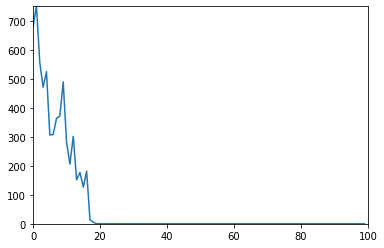

loss on validation set: 0.009943068969732849


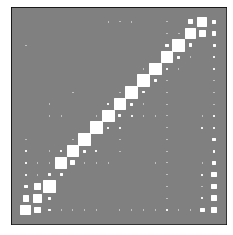

dcbacbadcbadcba


In [18]:
ENC_RNN_NUM_OF_LAYERS = 1
DEC_RNN_NUM_OF_LAYERS = 1
EMBEDDINGS_SIZE = 4
ENC_STATE_SIZE = 32
DEC_STATE_SIZE = 32

att = AttentionNetworkWithPrint(ENC_RNN_NUM_OF_LAYERS, DEC_RNN_NUM_OF_LAYERS, EMBEDDINGS_SIZE, ENC_STATE_SIZE, DEC_STATE_SIZE)
train(att, train_set, val_set)

att.att_mat = []
print(att.generate_and_plot_attention('abcdabcdabcdabcd'))

Test periodic dataset

In [0]:
from random import choice, randrange

EOS = "<EOS>" #all strings will end with the End Of String token
characters = list("abcdefg")
characters.append(EOS)

int2char = list(characters)
char2int = {c:i for i,c in enumerate(characters)}

VOCAB_SIZE = len(characters)

def sample_periodic_model(min_length, max_lenth):
    random_length = randrange(min_length, max_lenth)                             # Pick a random length
    random_char_list = [choice(characters[:-1]) for _ in range(random_length)]  # Pick random chars
    random_string = ''.join(random_char_list) 
    return random_string, random_string[1:] + random_string[0]  # Return the random string and its reverse

In [24]:
print(sample_model(4, 5))
print(sample_model(5, 10))

('ffef', 'feff')
('cfdfecbdf', 'fdfecbdfc')


In [0]:
MAX_STRING_LEN = 25

train_set = [sample_model(1, MAX_STRING_LEN) for _ in range(3000)]
val_set = [sample_model(1, MAX_STRING_LEN) for _ in range(50)]

In [0]:
val_set

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


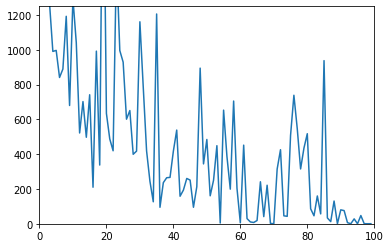

loss on validation set: 0.5753257968463004


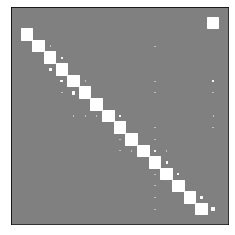

bcdabcdabcdabcda


In [69]:
ENC_RNN_NUM_OF_LAYERS = 1
DEC_RNN_NUM_OF_LAYERS = 1
EMBEDDINGS_SIZE = 4
ENC_STATE_SIZE = 32
DEC_STATE_SIZE = 32

att = AttentionNetworkWithPrint(ENC_RNN_NUM_OF_LAYERS, DEC_RNN_NUM_OF_LAYERS, EMBEDDINGS_SIZE, ENC_STATE_SIZE, DEC_STATE_SIZE)
train(att, train_set, val_set)

att.att_mat = []
print(att.generate_and_plot_attention('abcdabcdabcdabcd'))

In [0]:
short_strings = [sample_periodic_model(1, 5) for _ in range(100)]
medium_strings = [sample_periodic_model(5, 10) for _ in range(100)]
long_strings = [sample_periodic_model(10, 15) for _ in range(100)]

In [72]:
print('Matches for short strings', count_matches(att, short_strings))
print('Matches for medium strings', count_matches(att, medium_strings))
print('Matches for long strings', count_matches(att, long_strings))

Matches for short strings 100
Matches for medium strings 100
Matches for long strings 100


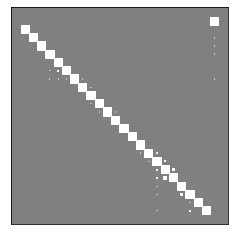

x  ebcadcgfafdedecggggccbf
y  bcadcgfafdedecggggccbfe
pred bcadcgfafdedecggggccbfe


True

In [75]:
x, y = sample_periodic_model(20, 25)
pred = att.generate_and_plot_attention(x)
print('x ', x)
print('y ', y)
print('pred', pred)
pred == y